# Sentiment Analysis with GoEmotions

This notebook builds an NLP pipeline for sentiment analysis using tf.data.Dataset pipelines.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\gabri\OneDrive\Documentos\projects\machine-learning\sentiment-analysis\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Data Loading and Cleaning

In [2]:
# load dataset
ds = tfds.load('goemotions', split='train')
df = tfds.as_dataframe(ds)

# decode bytes to strings
df['text'] = df['comment_text'].str.decode('utf-8')

# filter specific emotions
target_emotions = ['joy', 'sadness', 'anger', 'neutral']
target_map = {'joy': 0, 'sadness': 1, 'anger': 2, 'neutral': 3}

def get_label(row):
    active = [e for e in target_emotions if row[e] == 1]
    if len(active) == 1:
        return target_map[active[0]]
    return None

df['label'] = df.apply(get_label, axis=1)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# limit dataset size
df = df.sample(n=min(len(df), 40000), random_state=42)

class_names = ['Joy', 'Sadness', 'Anger', 'Neutral']

## Pipeline Creation

In [3]:
# split dataset
X = df['text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(weights))

# create dataset pipelines
BATCH_SIZE = 32

def make_dataset(texts, labels=None, shuffle=False):
    # convert to dataset
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    else:
        ds = tf.data.Dataset.from_tensor_slices(texts)
    
    # shuffle training data
    if shuffle:
        ds = ds.shuffle(buffer_size=len(texts))
    
    # batch data
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds = make_dataset(X_test, y_test)

## Model Definition

In [4]:
# setup vectorizer
vectorizer = layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=50
)

# adapt vectorizer
vectorizer.adapt(X_train)

# build model
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = layers.Embedding(input_dim=10000, output_dim=64)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 50)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,212 (2.45 MB)

 Trainable params: 642,212 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# get vocabulary
vocab = vectorizer.get_vocabulary()

# test vectorization
test_sentence = "I am so happy and excited!"
vectorized_output = vectorizer([test_sentence])

In [6]:
# train model
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    class_weight=weights_dict
)

Epoch 1/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1294 - loss: 1.3871 - val_accuracy: 0.7740 - val_loss: 1.3841
Epoch 2/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1673 - loss: 1.3865 - val_accuracy: 0.7740 - val_loss: 1.3819
Epoch 3/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3773 - loss: 1.3845 - val_accuracy: 0.1124 - val_loss: 1.3861
Epoch 4/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0930 - loss: 1.3718 - val_accuracy: 0.0799 - val_loss: 1.3075
Epoch 5/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2445 - loss: 1.2284 - val_accuracy: 0.3538 - val_loss: 1.1112
Epoch 6/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4464 - loss: 0.9758 - val_accuracy: 0.5715 - val_loss: 1.0445
Epoch 7/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6384 - loss: 0.7602 - val_accuracy: 0.7390 - val_loss: 0.8312
Epoch 8/15
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7346 - loss: 0.6086 - val_accuracy: 0.

## Prediction

In [7]:
examples = [
    "I was happy but now i'm sad", 
    "are you feeling good?",
    "I feel so alone and blue.",
    "The weather is okay today.",
]

# convert examples to dataset
predict_ds = make_dataset(examples, shuffle=False)

# generate predictions
preds = model.predict(predict_ds)

for i, text in enumerate(examples):
    label = class_names[np.argmax(preds[i])]
    conf = np.max(preds[i])
    print(f"'{text}' -> {label} ({conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
'I was happy but now i'm sad' -> Sadness (0.84)
'are you feeling good?' -> Joy (0.56)
'I feel so alone and blue.' -> Sadness (0.87)
'The weather is okay today.' -> Neutral (0.68)


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


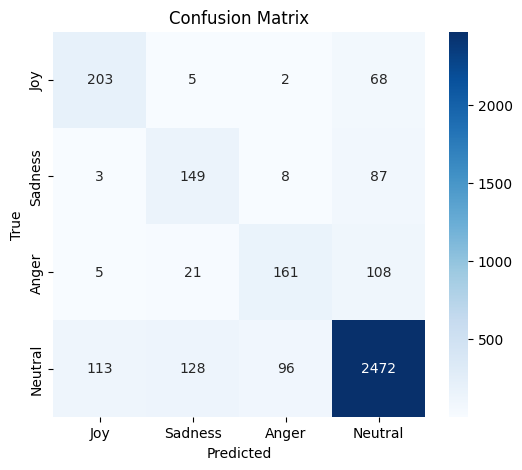

In [8]:
# generate predictions on validation set
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()